## 2025 HW\#5 Atari Breakout using DQN -- Starter Code

## 1. CoLab Setup

In [1]:
## Code piece to mount my Google Drive
from google.colab import drive
drive.mount("/content/drive") # my Google Drive root directory will be mapped here

Mounted at /content/drive


In [2]:
# Change the working directory to your own work directory (where the code file is).
import os
thisdir = '/content/drive/My Drive/CSC580_Winter2025/HW5'
os.chdir(thisdir)

# Ensure the files are there (in the folder)
!pwd

/content/drive/My Drive/CSC580_Winter2025/HW5


### 2. Install libraries related to graphics and Gymnasium

In [3]:
!apt-get update
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [66.7 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,309 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy/main amd64 Packages [57.8 kB]
Get:1

In [4]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import pyvirtualdisplay

In [5]:
# % to ensure the libraries are installed in the current environment
%pip install gymnasium[atari]
%pip install gymnasium[accept-rom-license]
%pip install ale-py     # critical for rendering Atari screens

In [6]:
# First import the ALE
from ale_py import ALEInterface

ale = ALEInterface()

### 3. Preliminary step to inspect states and rendering

action_space=4, observation_space=(210, 160, 3)


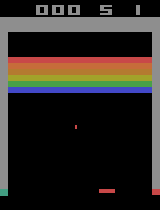

In [7]:
import gymnasium as gym

env = gym.make("ALE/Breakout-v5", render_mode='rgb_array', full_action_space=False)

# Various information about the environment
print ("action_space={}, observation_space={}".format(env.action_space.n, env.observation_space.shape))

observation = env.reset() # initial state/observation returned
#print (observation[0][180])
env.step(1) ## FIRE!

#env.render()  # returns an array of (210, 160, 3), each in the range [0-255]
Image.fromarray(env.render())

## 4. Install tensorflow

In [8]:
%pip install tensorflow

import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.18.0'

### (*) Image/frame preprocessing -- cropping, resizing and grayscale

[from https://towardsdatascience.com/getting-an-ai-to-play-atari-pong-with-deep-reinforcement-learning-47b0c56e78ae]<br>
Currently, the frames received from openai are much larger than we need, with a much higher resolution than we need.  We don’t need any of the white space at the bottom, or any pixel above the white stripe at the top.

So we first crop the image so that only the important area is displayed. Next, we convert the image to grayscale if desired. Finally we convert the image datatype to np.uint8 (to save space than regular int).

In [9]:
import numpy as np

def crop_Atari_frame(frame):
    return frame[30:-12,5:-4]  # crop out irrelevant parts in the frame/image

def resize_and_gray(frame, newsize, gray = False):
    """ converts the frame/image array, possibly reduce to the gray scale,
        then resizes to the new size.
    """
    frame = crop_Atari_frame(frame)       # first crop the frame/array
    im = Image.fromarray(np.uint8(frame)) # convert the array to a PIL image
    if gray:
      im = ImageOps.grayscale(im)  # convert to grayscale using PIL ImageOps

    im = im.resize(newsize)  # resize the PIL image to the desired size
    return np.array(im, dtype = np.uint8) # convert back to an np array


Image shape: (84, 84, 3)


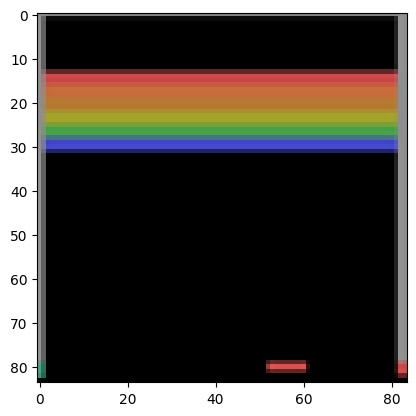

In [10]:
import gymnasium as gym
import matplotlib.pyplot as plt

env = gym.make("ALE/Breakout-v5", render_mode='rgb_array', full_action_space=False)
state = env.reset()
env.step(1)

newsize = (84, 84)  # reduced, new size!!

## convert the frame to a smaller color image
first_frame = resize_and_gray(state[0], newsize)  # new size, but still in color
print ("Image shape: {}".format(first_frame.shape))
plt.imshow(first_frame)

Image shape: (84, 84)


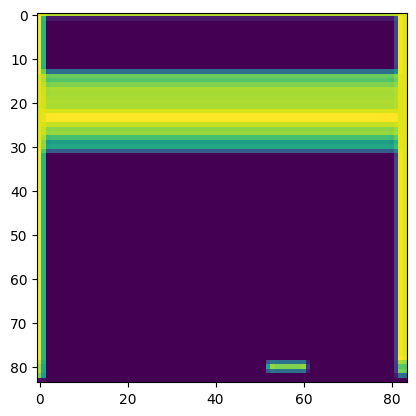

In [11]:
## convert the frame to a smaller grayscale image
first_frame = resize_and_gray(state[0], newsize, True) # new size, in grayscale
print ("Image shape: {}".format(first_frame.shape))
plt.imshow(first_frame)

## 5. Define QNetwork and Memory

In [12]:
from tensorflow.keras import layers
from collections import deque

class QNetwork:
    def __init__(self, input_shape=(84, 84, 3), action_size=4, hidden_size=126,
                 learning_rate = 0.001):
        # First fix up input_shape in case it is a 2D grayscale image
        if len(input_shape) < 3:
            input_shape = (input_shape[0], input_shape[1], 1)
        print ('input_shape = {}'.format(input_shape))

        # Model in the original Deepmind DQN paper (but reduced to assume one frame)
        self.model = keras.Sequential()
        self.model.add(layers.Conv2D(32, 8, strides=4, activation="relu",
                                    input_shape=input_shape))
        self.model.add(layers.Conv2D(64, 4, strides=2, activation="relu"))
        self.model.add(layers.Conv2D(64, 3, strides=1, activation="relu"))
        self.model.add(layers.Flatten())
        self.model.add(layers.Dense(hidden_size, activation="relu"))
        self.model.add(layers.Dense(action_size, activation="linear"))

        # other compile parameters
        self.optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
        self.model.compile(loss=keras.losses.Huber(), optimizer=self.optimizer)


class Memory():
    """ Replay memory """
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)),
                               size=batch_size,
                               replace=False)
        return [self.buffer[ii] for ii in idx]

    def __len__(self):
        return len(self.buffer)

### 6. Fill the Memory with episode steps

In [13]:
###################################
## Populate the experience memory
###################################

# Newly create the Atari Breakout game environment
env = gym.make("ALE/Breakout-v5", render_mode='rgb_array', full_action_space=False)
newsize = (84, 84)
grayscale = False

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 16                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

INIT_MEMORY = 100

memory = Memory(max_size=memory_size)

#----------------
print ("* Populate the experience memory with {} steps *".format(INIT_MEMORY))

# Initialize the simulation
observation = env.reset()
state = resize_and_gray(observation[0], newsize)

# Make a bunch of random actions and store the experiences
for _ in range(INIT_MEMORY):
    # render commented since it doesn't work well on CoLab without video
    #env.render()

    # Make a/one random action
    action = env.action_space.sample()
    # take the action
    next_state, reward, done, info, _ = env.step(action)

    # resize the image of next_state
    next_state = resize_and_gray(next_state, newsize, grayscale)

    # Add experience (a four-tuple) to memory.
    # (**) Keras predict processes a batch, so when you're using a single
    #  image, you need to add it to a list (by expanding the row dimension):
    memory.add((np.expand_dims(state, axis=0), action, reward,
                np.expand_dims(next_state, axis=0), done))

    if done:
        # Start a new episode
        env.reset()
        # Take one random step to get started
        state, reward, done, info = env.step(env.action_space.sample())
        state = resize_and_gray(state, newsize, grayscale)
    else:
        # go to the next state
        state = next_state

print ("Done!")

* Populate the experience memory with 100 steps *
Done!


## 7. Create DQN networks ('model_pred', which utilizes 'model_target') as Agent

In [14]:
# The first model makes the predictions for Q-values which are used to
# make a action.
image_shape = (memory.buffer[0][0][0]).shape
num_actions = env.action_space.n

model_pred = QNetwork(input_shape = image_shape, action_size = num_actions,
                      hidden_size=126)

# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 1000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = QNetwork(input_shape = image_shape, action_size = num_actions,
                        hidden_size=126)

input_shape = (84, 84, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


input_shape = (84, 84, 3)


Some code to inspect memory, states etc.

(1, 84, 84, 3)


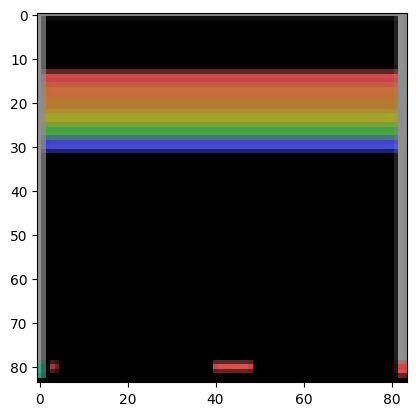

In [15]:
frame = memory.sample(1)[0]
frame_state = frame[0]      # 1st element in the four tuple
print(frame_state.shape)    # still in a batch of one

plt.imshow(frame_state[0])  # show only the image

(**) Convert the image into range \[0, 1\], then call 'predict' in model_pred.model

In [16]:
# convert values of the image into range [0, 1]
frame_state = frame_state / 255.0

# Now make predictions (for all actions)
predictions = model_pred.model.predict(frame_state)
print (predictions[0])  # [0] because there is only one result in predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[-0.01018261 -0.03667003  0.00377788  0.02124413]


# 8. Your Training Code goes here!!!

## 9. Try out the learned policy!!

Utility functions related to video

In [17]:
from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo
gymlogger.set_level(40) #error only
import glob
import io
from IPython import display as ipythondisplay
from IPython.display import HTML

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

def wrap_env(env):
  env = RecordVideo(env, './video',  episode_trigger = lambda episode_number: True)
  return env

(**)

In [18]:
# First wrap the enviroment in a video-recording environment
env = wrap_env(env)

num_episodes = 1
total_score = 0

newsize = (84, 84)

for _ in range(num_episodes):
    # for each episode
    observation = env.reset()
    state = resize_and_gray(observation[0], newsize)
    done = False
    score = 0

    #while not done:
    for i in range(50):
        if i % 4 == 0:
          env.render()

        # Get action from the model_pred
        state = state / 255.0
        predictions = model_pred.model.predict(np.expand_dims(state, axis=0), verbose=0)[0]
        max_indices = np.where(predictions == np.max(predictions))[0]  # indices of max values
        action = np.random.choice(max_indices)  # break the ties randomly

        #action = np.argmax()

        # take the action
        next_state, reward, done, info = env.step(action)
        next_state = resize_and_gray(next_state, newsize, grayscale)

        score += reward
        state = next_state

env.close()
show_video()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
